# 0.0 Imports


In [355]:
import pandas as pd
import numpy as np
import inflection

import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2 as pg
import pickle

from sklearn import model_selection as ms
from sklearn import metrics as mt
from sklearn import linear_model as lm
from sklearn import tree as tr
from sklearn import preprocessing as pp
from sklearn import ensemble as en
from sklearn import neighbors as ng
from boruta import BorutaPy

import scikitplot as sktplt


In [356]:
np.version

<module 'numpy.version' from '/home/alexandrerod/anaconda3/envs/HealthInsurance/lib/python3.11/site-packages/numpy/version.py'>

## 0.1 Helper Functions

In [415]:
def precision_at_k(X_test, y_test, yhat, k=20000):

    data = X_test.copy()
    data['response'] = y_test.copy()

   

    data['score'] = yhat[:,1].tolist()
    data = data.sort_values('score', ascending=False)


    data = data.reset_index(drop=True)
    data['ranking'] = data.index +1 

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k,'precision_at_k']

def recall_at_k(X_test, y_test, k=20000):

    data = X_test.copy()
    data['response'] = y_test.copy()


    data = data.reset_index(drop=True)
    data['ranking'] = data.index +1 

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k,'recall_at_k']


def model_result(model_name,X_test,y_test, yhat,k=20000):
    name = model_name
    precision = precision_at_k(X_test,y_test,yhat,k)
    recall = recall_at_k(X_test, y_test,k)


    return pd.DataFrame({'Model name': name, 'Precision at k': precision, 'Recall at k': recall}, index=[0])


def cross_validation(model_name,model,x_train, y_train, kfold=5):

    skf = ms.StratifiedKFold(n_splits=kfold, shuffle=True, random_state=42)

    precision_list = []
    recall_list = []

    for train_index, val_index in skf.split(x_train,y_train):
        x_train_cv, x_val_cv = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

        #model definidtion
        m = model.fit(x_train_cv, y_train_cv)
        yhat_cv = m.predict_proba(x_val_cv)
        ml_cv_result = model_result(model_name, x_val_cv, y_val_cv, yhat_cv, k=20000)
        precision_list.append(ml_cv_result['Precision at k'])
        recall_list.append(ml_cv_result['Recall at k'])
        

        metric = pd.DataFrame({'Model name': model_name, 'Precision at k': np.mean(precision_list), 'Recall at k': np.mean(recall_list)}, index=[0])

    return metric
    

## 0.2 Load Data

In [358]:
data_train_raw = pd.read_csv('../inputs/train.csv')
data_test_raw = pd.read_csv('../inputs/test.csv')

## 0.3 Rename Columns

In [359]:
#old columns
cols_old = list(data_train_raw.columns)
#creating function
rename_columns = lambda x: inflection.underscore(x)
#new columns
cols_new = list(map(rename_columns, cols_old))
#renaming columns 
data_train_raw.columns = cols_new

## 0.3 Split dataset

In [360]:
data_train_raw

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


In [361]:
X = data_train_raw.drop('response', axis=1)
y = data_train_raw[['response']]


In [362]:
X_train, X_test, y_train, y_test = ms.train_test_split(X,y, test_size=0.3, random_state=42)

In [363]:
#train dataset
df_train = pd.concat([X_train, y_train], axis=1)

#test dataset
df_test = pd.concat([X_test, y_test], axis=1)

In [364]:
df_train.sample(5)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
26515,26516,Male,25,1,14.0,1,< 1 Year,No,27308.0,152.0,138,0
153475,153476,Male,41,1,28.0,0,1-2 Year,Yes,62353.0,55.0,98,0
59079,59080,Male,24,1,50.0,1,< 1 Year,No,21607.0,152.0,119,0
6631,6632,Male,54,1,24.0,0,> 2 Years,Yes,36515.0,124.0,70,0
175869,175870,Male,69,1,17.0,1,1-2 Year,No,54397.0,30.0,227,0


# 1.0 Data Description

In [365]:
df1 = df_train.copy()


- 'id': 	'Unique ID for the customer',
- 'Gender': 	'Gender of the customer',
- 'Age': 	'Age of the customer',
- 'Driving_License': 	'0 : Customer does not have DL, 1 : Customer already has DL',
- 'Region_Code': 	'Unique code for the region of the customer',
- 'Previously_Insured': 	'1 : Customer already has Vehicle Insurance, 0 : Customer doesnt have Vehicle Insurance',
- 'Vehicle_Age': 	'Age of the Vehicle',
- 'Vehicle_Damage': 	'1 : Customer got his/her vehicle damaged in the past. 0 : Customer didnt get his/her vehicle damaged in the past.',
- 'Annual_Premium': 	'The amount customer needs to pay as premium in the year',
- 'Policy_Sales_Channel': 	'Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.',
- 'Vintage': 	'Number of Days, Customer has been associated with the company',
- 'Response': 	'1 : Customer is interested, 0 : Customer is not interested'}



# 1.1 Data amount

In [366]:
print('Quantidade de linhas: {}'.format(df1.shape[0]))
print('Quantidade de colunas: {}'.format(df1.shape[1]))


Quantidade de linhas: 266776
Quantidade de colunas: 12


## 1.2 Data Types

In [367]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NaN

In [368]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Descriptive Statistical

In [369]:
numerical_features = df1.select_dtypes(include=['int64', 'float64'])
categorical_features = df1.select_dtypes(exclude=['int64','float64'])

### 1.4.1 Numerical Features

In [370]:
#Têndencia central
t01 = pd.DataFrame(numerical_features.apply(np.mean)).T
t02 = pd.DataFrame(numerical_features.apply(np.median)).T
#Dispersão dos dados
d01 = pd.DataFrame(numerical_features.apply(np.min)).T
d02 = pd.DataFrame(numerical_features.apply(np.max)).T
d03 = pd.DataFrame(numerical_features.apply(lambda x: x.max() - x.min())).T
d04 = pd.DataFrame(numerical_features.apply(np.std)).T
d05 = pd.DataFrame(numerical_features.apply(lambda x: x.skew())).T
d06 = pd.DataFrame(numerical_features.apply(lambda x: x.kurtosis())).T

m = pd.concat([d01,d02,d03,t01,t02,d04,d05,d06]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skewness','kurtosis']
m


,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,id,2.0,381108.0,381106.0,190548.259180,190543.5,110059.963886,0.000641,-1.200396
1,age,20.0,85.0,65.0,38.851666,36.0,15.514605,0.668177,-0.573076
2,driving_license,0.0,1.0,1.0,0.997833,1.0,0.046496,-21.413956,456.560924
3,region_code,0.0,52.0,52.0,26.414434,28.0,13.214633,-0.118152,-0.862541
4,previously_insured,0.0,1.0,1.0,0.458310,0.0,0.498259,0.167345,-1.972010
5,annual_premium,2630.0,540165.0,537535.0,30580.218359,31680.0,17260.707353,1.862794,36.726254
6,policy_sales_channel,1.0,163.0,162.0,111.938139,128.0,54.243147,-0.896198,-0.978290
7,vintage,10.0,299.0,289.0,154.277158,154.0,83.670336,0.004882,-1.200055
8,response,0.0,1.0,1.0,0.122095,0.0,0.327395,2.308567,3.329508


### 1.4.2 Categorical Features

In [371]:
categorical_features.nunique()

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

# 2.0 Feature Engineering

In [372]:
df2 = df1.copy()

## 2.1 Hypothesis Map

1. Índice de Criminalidade da Região influência na contratação do seguro veicular
2. Clientes com maior salário contratariam o seguro veicular
3. Clientes com carros mais novos contratariam o seguro veicular
4. Pessoas mais velhas contratariam o seguro veicular
5. Clientes cujo veículo já sofreu danos contratariam o seguro veicular
6. Somente clientes habilitados contratariam o seguro veicular
7. Clientes mais antigos da seguradora contratariam o seguro veicular
8. Clientes com carros mais novos contratam o seguro veicular

# 3.0 Data Filtering

In [373]:
df3 = df2.copy()

# 4.0 Exploratory Data Analysis

In [374]:
df4 = df3.copy()
df4.sample(5)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
8526,8527,Female,44,1,28.0,0,1-2 Year,Yes,47650.0,26.0,182,0
378671,378672,Male,24,1,45.0,1,< 1 Year,No,2630.0,152.0,98,0
73762,73763,Male,28,1,16.0,1,< 1 Year,No,2630.0,160.0,288,0
296727,296728,Female,40,1,28.0,1,1-2 Year,No,60069.0,26.0,87,0
30491,30492,Male,38,1,41.0,1,1-2 Year,No,29228.0,160.0,247,0


## 4.1 Univariate Analysis

### 4.1.1 Numerical Features

In [375]:
df4.select_dtypes(include=['int64','float64']).columns

Index(['id', 'age', 'driving_license', 'region_code', 'previously_insured',
       'annual_premium', 'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

<Axes: xlabel='age'>

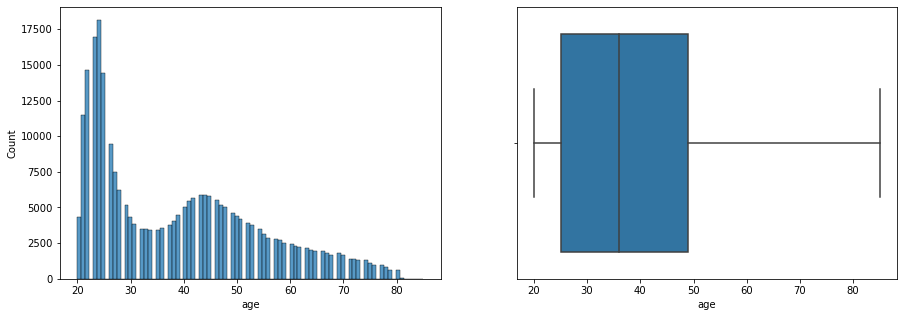

In [376]:
#Age  - Client Age
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df4, x='age')
plt.subplot(1,2,2)
sns.boxplot(data=df4, x='age')

Como identificado na secção **1.4** a feature Age tem assimetria positiva indicando maior concentração no lado esquerdo do histograma na faixa de idade de 22 e 27 anos aproximadamente. Além de indicar que moda < mediana < média

<Axes: xlabel='annual_premium'>

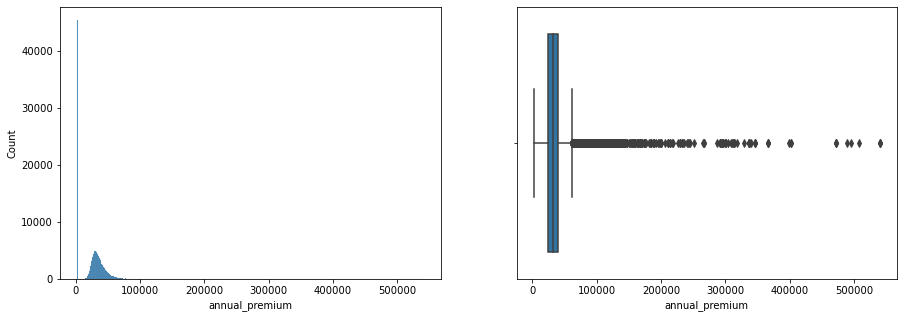

In [377]:
#Annual Premium
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df4, x='annual_premium')
plt.subplot(1,2,2)
sns.boxplot(data=df4, x='annual_premium')

<Axes: xlabel='vintage'>

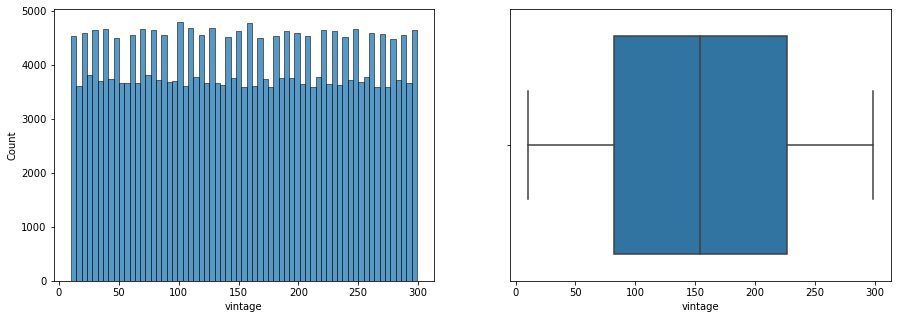

In [378]:
# Vintage 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df4, x='vintage')
plt.subplot(1,2,2)
sns.boxplot(data=df4, x='vintage')

### 4.1.2 Categorical Features

<Axes: xlabel='driving_license', ylabel='count'>

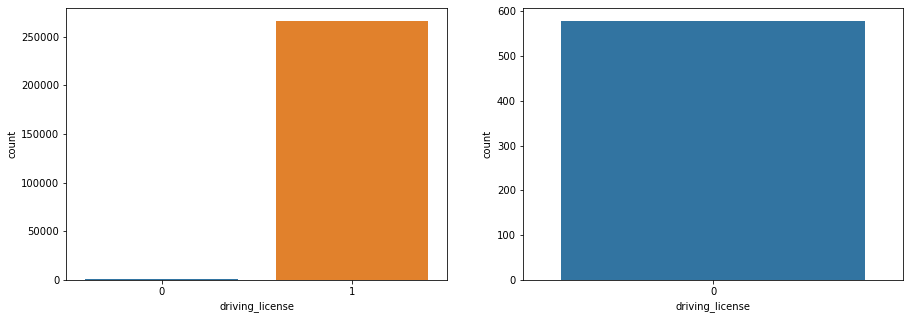

In [379]:
#Driving Licence
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x='driving_license')
plt.subplot(1,2,2)
aux = df4.loc[df4['driving_license'] == 0, :].reset_index()
# sns.countplot(data=aux, x='driving_license')
sns.countplot(data=aux, x='driving_license')


<Axes: xlabel='previously_insured', ylabel='count'>

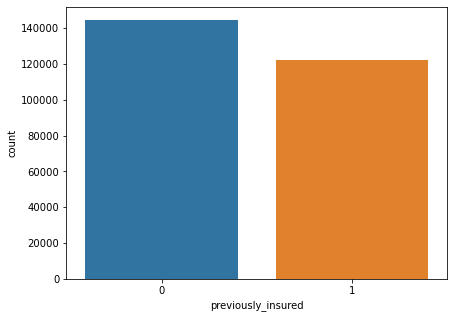

In [380]:
# previously_insured

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x='previously_insured')

<Axes: xlabel='gender', ylabel='count'>

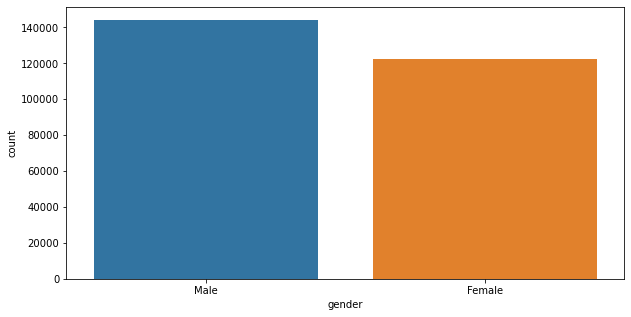

In [381]:
#gender
plt.figure(figsize=(10,5))
sns.countplot(data=df4, x= 'gender') 

<Axes: xlabel='vehicle_age', ylabel='count'>

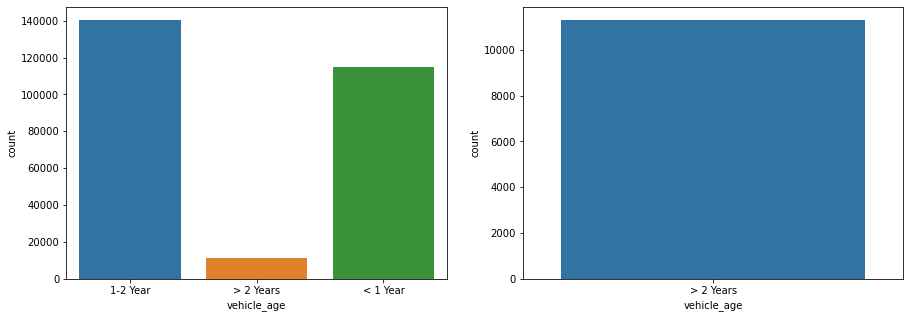

In [382]:
#vehicle_age
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x= 'vehicle_age') 
plt.subplot(1,2,2)
aux = df4.loc[df4['vehicle_age'] == '> 2 Years',:]
sns.countplot(data=aux, x='vehicle_age')

<Axes: xlabel='vehicle_damage', ylabel='count'>

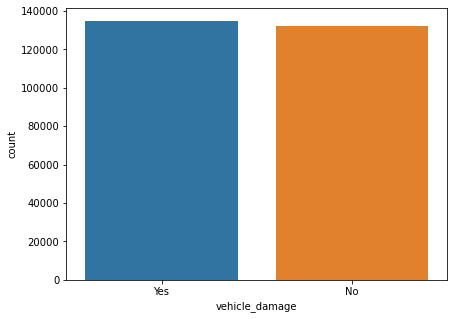

In [383]:
#vehicle_damage
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x= 'vehicle_damage')

<Axes: xlabel='response', ylabel='count'>

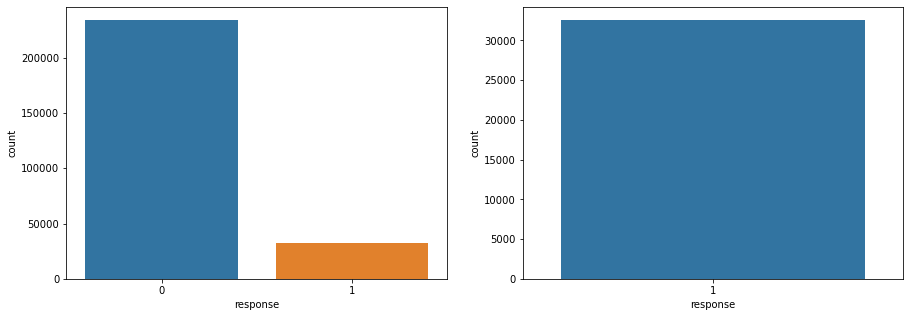

In [384]:
# Response

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df4, x='response')
plt.subplot(1,2,2)
aux = df4.loc[df4['response'] == 1, :]
sns.countplot(data=aux, x='response')

<Axes: xlabel='region_code'>

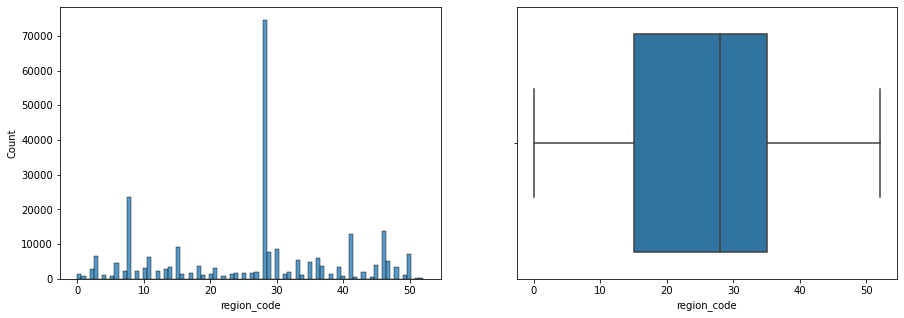

In [385]:
#region_code
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data=df4, x='region_code')
plt.subplot(1,2,2)
sns.boxplot(data=df4, x='region_code')

## 4.2 Bivariate Analysis

### H3. Clientes com carros novos com menos de um ano contratariam o seguro veicular
 

<Axes: xlabel='vehicle_age', ylabel='response'>

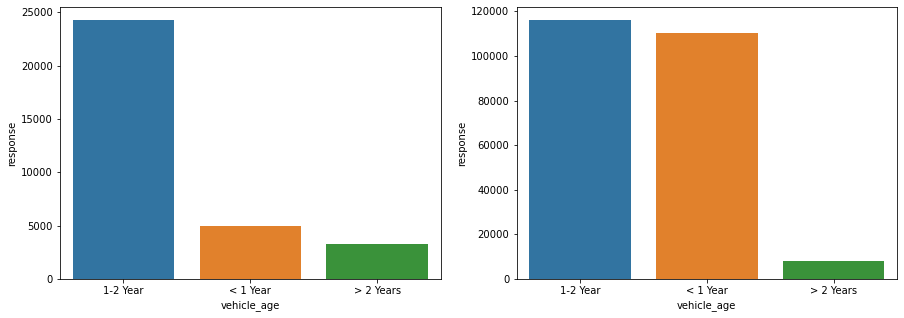

In [386]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
aux = df4.loc[df4['response'] == 1, ['response', 'vehicle_age']].groupby(['vehicle_age']).count().reset_index()
sns.barplot(data=aux, x='vehicle_age', y='response')
plt.subplot(1,2,2)
aux1 = df4.loc[df4['response'] == 0, ['response', 'vehicle_age']].groupby(['vehicle_age']).count().reset_index()
sns.barplot(data=aux1, x='vehicle_age', y='response')


In [387]:
total_response_v = len(df4.loc[df4['response'] == 1,:])
############## Para menos de um ano #################
total_less_oney = len(df4.loc[(df4['response'] == 1) & (df4['vehicle_age'] == '< 1 Year'),:])
percentage_less_oney = total_less_oney/total_response_v
print('Total de pessoas que contratariam o seguro veicular e o carro tem menos de um ano: {:.4f}'.format(percentage_less_oney))

############## Entre um e dois anos #################
total_less_oney = len(df4.loc[(df4['response'] == 1) & (df4['vehicle_age'] == '1-2 Year'),:])
percentage_bwt_onetwo = total_less_oney/total_response_v
print('Total de pessoas que contratariam o seguro veicular e o carro tem entre um e dois anos: {:.4f}'.format(percentage_bwt_onetwo))

Total de pessoas que contratariam o seguro veicular e o carro tem menos de um ano: 0.1537
Total de pessoas que contratariam o seguro veicular e o carro tem entre um e dois anos: 0.7452


Como apenas 15% das pessoas que tem o carro a menos de um ano contratariam o seguro a hipótese **H3** é falsa. Além disso, 74% das pessoas que contratariam o seguro tem o carro entre 1 e 2 anos.

### H4. Pessoas acima dos 30 anos contratariam o seguro veicular


/tmp/ipykernel_81033/2479584926.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['age_binned'] = pd.cut(aux['age'], bins)


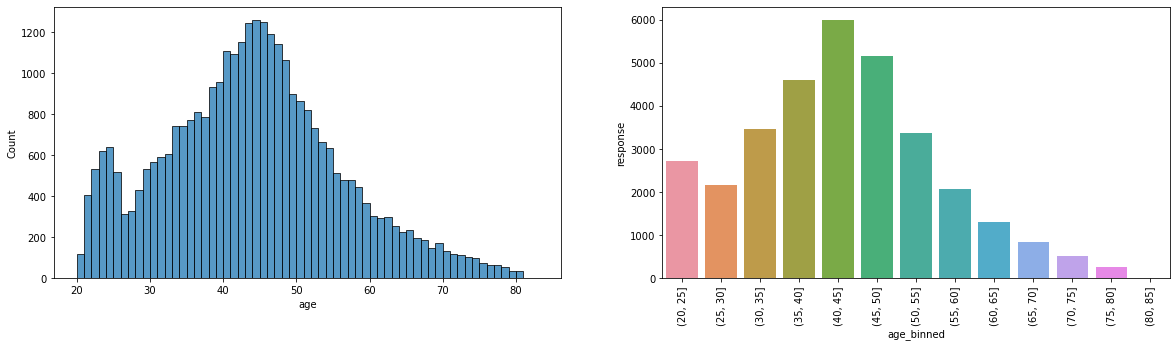

In [388]:
aux = df4.loc[df4['response'] == 1,:]
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.histplot(data=aux, x='age')
plt.subplot(1,2,2)
bins = np.arange(20,90,5)
aux['age_binned'] = pd.cut(aux['age'], bins)
aux2 = aux.loc[:, ['response', 'age_binned']].groupby(['age_binned']).sum().reset_index()
sns.barplot(data=aux2, x='age_binned',y='response')
plt.xticks(rotation=90);

In [389]:
less_30 =len(aux.loc[aux['age'] <30, : ])/len(aux)
higher_30 = len(aux.loc[aux['age'] >30, : ])/len(aux)
print('Total de pessoas que contratariam o seguro e tem mais de 30 anos: {:.4f}'.format(higher_30))
print('Total de pessoas que contratariam o seguro e tem menos de 30 anos: {:.4f}'.format(less_30))


Total de pessoas que contratariam o seguro e tem mais de 30 anos: 0.8462
Total de pessoas que contratariam o seguro e tem menos de 30 anos: 0.1364


Hipótese é **verdadeira**, aproximadamente 85% das pessoas que contratariam o seguro tem mais de 30 anos de idade

### H5. Clientes cujo veículo já sofreu danos contratariam o seguro veicular

In [390]:
df4['vehicle_damage'].value_counts(normalize=True)

vehicle_damage
Yes    0.5053
No     0.4947
Name: proportion, dtype: float64

### H6. Somente clientes habilitados contratariam o seguro veicular


In [391]:
df4['driving_license'].value_counts(normalize=True)

driving_license
1    0.997833
0    0.002167
Name: proportion, dtype: float64

Hipótese verdadeira, 99,7% dos clientes que contratariam o seguro são habilitados.

### H7. Clientes mais antigos da seguradora contratariam o seguro veicular


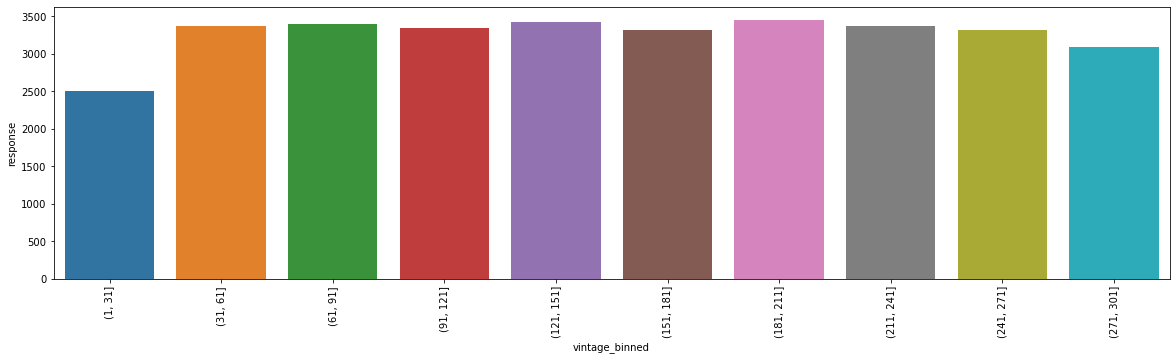

In [392]:
aux = df4.loc[df4['response'] == 1, ['response', 'vintage']]
plt.figure(figsize=(20,5))
bins = np.arange(1,320,30)
aux['vintage_binned'] = pd.cut(aux['vintage'], bins = bins)
aux2 = aux.loc[:, ['response','vintage_binned']].groupby(['vintage_binned']).sum().reset_index()
sns.barplot(data=aux2,x='vintage_binned', y='response')
plt.xticks(rotation=90);


## 4.3 Multivariate Analysis

<Axes: >

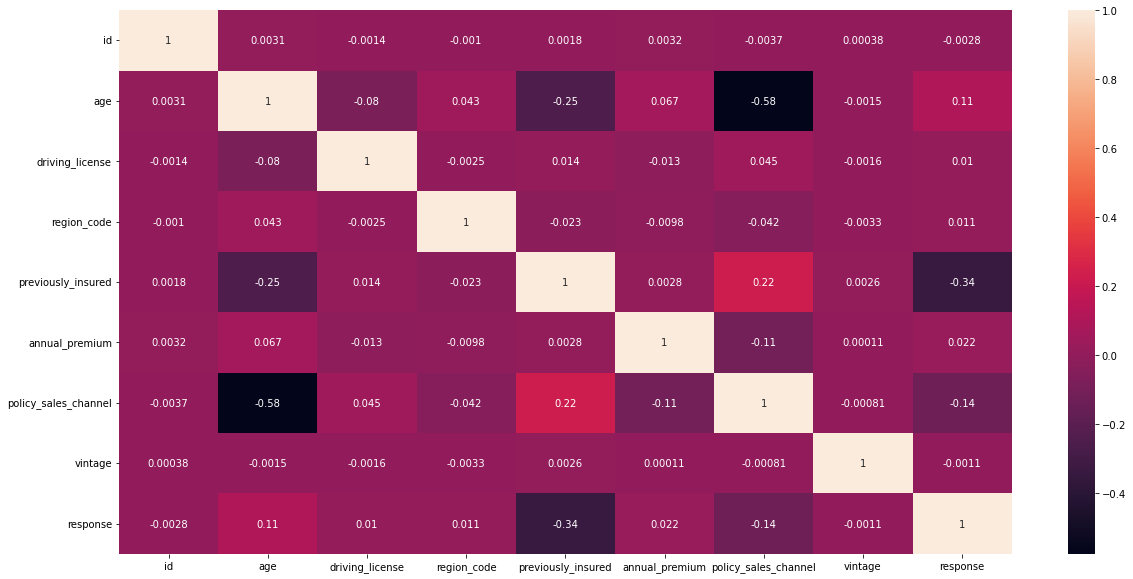

In [393]:

plt.figure(figsize=(20,10))
sns.heatmap(numerical_features.corr('pearson'), annot=True)



# 5.0 Data Preparation

In [394]:
df5 = df4.copy()
df5.sample(5)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
240051,240052,Male,46,1,14.0,0,1-2 Year,Yes,33721.0,124.0,27,1
249637,249638,Male,40,1,41.0,0,1-2 Year,Yes,21717.0,124.0,287,0
26243,26244,Male,23,1,28.0,0,1-2 Year,Yes,2630.0,158.0,92,0
2907,2908,Male,38,1,28.0,0,1-2 Year,Yes,24197.0,26.0,258,0
316530,316531,Female,36,1,8.0,0,1-2 Year,Yes,25117.0,19.0,148,0


### 5.1 Encodind

In [395]:
################# Train Data ###############

le_vehicle_age = pp.LabelEncoder()



#gender train
df5 = pd.get_dummies(df5, prefix=['gender'], columns=['gender']  ,dtype='int64')

#gender test
df_test = pd.get_dummies(df_test, prefix=['gender'], columns=['gender'], dtype='int64' )

#vehicle_age train
df5['vehicle_age'] = le_vehicle_age.fit_transform(df5[['vehicle_age']].values)
#vehicle_age test
df_test['vehicle_age'] = le_vehicle_age.transform(df_test[['vehicle_age']].values)

#vehicle_damage train
df5 = pd.get_dummies(df5, prefix=['vehicle_damage'], columns=['vehicle_damage'] ,dtype='int64' )

#vehicle_damage test
df_test = pd.get_dummies(df_test, prefix=['vehicle_damage'], columns=['vehicle_damage'], dtype='int64'  )




/home/alexandrerod/anaconda3/envs/HealthInsurance/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alexandrerod/anaconda3/envs/HealthInsurance/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


### 5.3 Rescaling

In [396]:
rs_annual = pp.RobustScaler()
rs_vintage = pp.RobustScaler()

mms_age= pp.MinMaxScaler()
mms_region = pp.MinMaxScaler()
mms_policy = pp.MinMaxScaler()



#age train
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age,open('../parameters/age_scaler.pkl', 'wb'))
#age test
df_test['age'] = mms_age.transform(df_test[['age']].values)

#region_code train
df5['region_code'] = mms_region.fit_transform(df5[['region_code']].values)
pickle.dump(mms_region, open('../parameters/region_scaler.pkl', 'wb'))
#region_code test
df_test['region_code'] = mms_region.transform(df_test[['region_code']].values)

#annual_premium train
df5['annual_premium'] = rs_annual.fit_transform(df5[['annual_premium']].values)
pickle.dump(rs_annual, open('../parameters/annual_premium.pkl', 'wb'))

#annual_premium test
df_test['annual_premium'] = rs_annual.transform(df_test[['annual_premium']].values)

#policy_sales_channel train
df5['policy_sales_channel'] = mms_policy.fit_transform(df5[['policy_sales_channel']].values)
pickle.dump(mms_policy, open('../parameters/policy_chanel_scaler.pkl', 'wb'))

#policy_sales_channel test
df_test['policy_sales_channel'] = mms_policy.transform(df_test[['policy_sales_channel']].values)

#vintage train
df5['vintage'] = rs_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(rs_vintage, open('../parameters/vintage_scaler.pkl', 'wb'))
#vintage test
df_test['vintage'] = rs_vintage.transform(df_test[['vintage']].values)


# 6.0 Feature Selection

In [397]:
X_train = df5.drop('response', axis=1)
y_train = df5['response']

X_test = df_test.drop('response', axis=1)
y_test = df_test['response']

print('Number of rows in x_train: {}'.format(len(X_train)))
print('Number of rows in x_test: {}'.format(len(X_test)))
print('Number of rows in y_train: {}'.format(len(y_train)))
print('Number of rows in y_teste: {}'.format(len(y_test)))


Number of rows in x_train: 266776
Number of rows in x_test: 114333
Number of rows in y_train: 266776
Number of rows in y_teste: 114333


## 6.1 Boruta as Feat Selector

In [398]:
# X_train_n = X_train.values
# y_train_n = y_train.ravel()

# rf= en.RandomForestClassifier(n_jobs=-1, max_depth=5)

## 6.2 Features Select from boruta

In [399]:
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# boruta.fit(X_train_n, y_train_n)

In [400]:
# cols_selected = boruta.support_.tolist()
# cols_selected
# X_train_fs = X_train
# cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.tolist()
# cols_selected_boruta


## 6.3 Manual Feature Selection

In [401]:
cols_selected_boruta = ['age',
 'driving_license',
 'region_code',
 'previously_insured',
 'vehicle_age',
 'annual_premium',
 'policy_sales_channel',
 'gender_Female',
 'gender_Male',
 'vehicle_damage_No',
 'vehicle_damage_Yes']

# 7.0 Machine Learning Modelling

In [402]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]


## 7.1 KNN

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

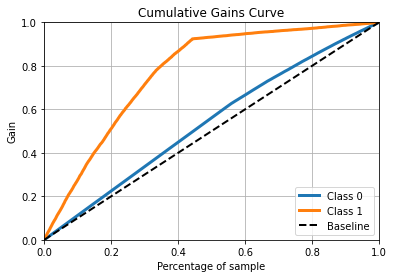

In [416]:
knn = ng.KNeighborsClassifier(n_neighbors=10)

#model training
knn.fit(x_train, y_train)

#predict

yhat_knn = knn.predict_proba(x_test)
#performance
sktplt.metrics.plot_cumulative_gain(y_test, yhat_knn)

#### 7.1.1 KNN - CROSS VALIDATION

In [417]:
knn_cv = cross_validation('KNN CV', knn, x_train,y_train, kfold=5)
knn_cv

,Model name,Precision at k,Recall at k
0,KNN CV,0.270856,0.37827


## 7.2 Decision Three

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

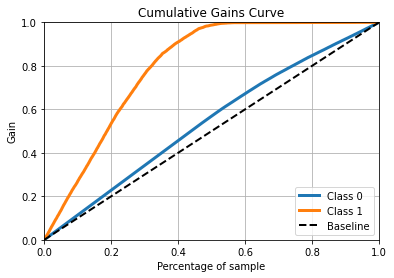

In [427]:
model_tr = tr.DecisionTreeClassifier(max_depth=5)

model_tr.fit(x_train, y_train)

yhat_tr = model_tr.predict_proba(x_test)
sktplt.metrics.plot_cumulative_gain(y_test, yhat_tr)

#### 7.2.1 Decision Tree Cross Validation

In [429]:
tr_cv = cross_validation('Decision Tree CV', model_tr, x_train, y_train, kfold=5)
tr_cv

,Model name,Precision at k,Recall at k
0,Decision Tree CV,0.286416,0.37827


## 7.3 Random Forest

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

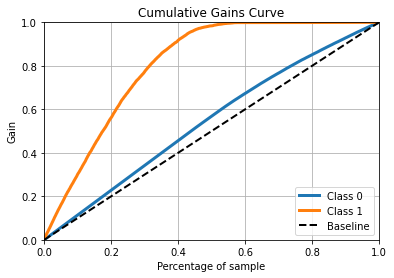

In [428]:
#model definition
 
rf= en.RandomForestClassifier(n_estimators= 1000,max_depth=5, n_jobs=-1, random_state=42)
#model training
rf.fit(x_train, y_train)
yhat_rf = rf.predict_proba(x_test)
sktplt.metrics.plot_cumulative_gain(y_test, yhat_rf)

#### 7.3.1 Random Forest Cross Validation

In [430]:
rf_cv = cross_validation('Random Forest CV', rf, x_train, y_train, kfold=5)
rf_cv

,Model name,Precision at k,Recall at k
0,Random Forest CV,0.287896,0.37827


## 7.5 Model Performance

### 7.5.1 KNN

In [422]:
df_knn = x_test.copy()
df_knn['response'] = y_test.copy()
#propensity score 

df_knn['score'] = yhat_knn[:,1].tolist()

df_knn = df_knn.sort_values('score', ascending=False)

result_knn  = model_result('Knn', x_test, y_test, yhat_knn ,2000)
result_knn.columns


Index(['Model name', 'Precision at k', 'Recall at k'], dtype='object')

### 7.5.2 Decision Tree

In [431]:
df_tr = x_test.copy()
df_tr['response'] = y_test.copy()

#propensity score
df_tr['score'] = yhat_tr[:,1].tolist()

df_tr = df_tr.sort_values('score', ascending=False)

result_tr = model_result('Decision Tree', x_test, y_test,yhat_tr, 2000)
result_tr

,Model name,Precision at k,Recall at k
0,Decision Tree,0.318341,0.018036


### 7.5.3 Random Forest

In [432]:
df_rf = x_test.copy()
df_rf['response'] = y_test.copy()

#propensity score

df_rf['score'] = yhat_rf[:,1].tolist()

df_rf = df_rf.sort_values('score', ascending=False)

result_rf = model_result('Random Forest', x_test,y_test,yhat= yhat_rf,k=2000)
result_rf


,Model name,Precision at k,Recall at k
0,Random Forest,0.416292,0.018036


## 7.6 Compare model performance


In [433]:
final_performance = pd.concat([result_knn, result_tr, result_rf])
final_performance.reset_index(drop=True)

,Model name,Precision at k,Recall at k
0,Knn,0.368816,0.018036
1,Decision Tree,0.318341,0.018036
2,Random Forest,0.416292,0.018036


In [434]:
performance_cv= pd.concat([knn_cv,tr_cv, rf_cv])
performance_cv.reset_index(drop=True)

,Model name,Precision at k,Recall at k
0,KNN CV,0.270856,0.37827
1,Decision Tree CV,0.286416,0.37827
2,Random Forest CV,0.287896,0.37827
